In [1]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import threading
import pygame
import random
import mido
import math
import os

class Boid:
  def __init__(self, x, y):
    self.acceleration = vec2(0, 0)
    angle = random.uniform(0, 2*math.pi)
    self.velocity = vec2(math.cos(angle), math.sin(angle))
    self.position = vec2(x, y)
    self.r = 2.0
    self.max_velocity = 2
    self.max_acceleration = 0.03
  
  def seek(self, target):
    desired = target - self.position
    desired = desired.normalized()
    desired *= self.max_velocity
    steer = desired - self.velocity
    steer = steer.limited(self.max_acceleration)
    return steer
  
  # Wraparound
  def borders(self):
    x, y = self.position
    x = (x+self.width) % self.width
    y = (y+self.height) % self.height
    self.position = vec2(x,y)
  
  # Separation: Method checks for nearby boids and steers away
  def separate(self, boids):
    desired_separation = 25.0
    steer = vec2(0, 0)
    count = 0
    # For every boid in the system, check if it's too close
    for other in boids:
      d = (self.position - other.position).length()
      # If the distance is greater than 0 and less than an arbitrary
      # amount (0 when you are yourself)
      if 0 < d < desired_separation:
        # Calculate vector pointing away from neighbor
        diff = self.position - other.position
        diff = diff.normalized()
        steer += diff/d  # Weight by distance
        count += 1     # Keep track of how many
    # Average - divide by how many
    if count > 0:
      steer /= count
    # As long as the vector is greater than 0
    if steer.length() > 0:
      # Implement Reynolds: Steering = Desired - Velocity
      steer = steer.normalized()
      steer *= self.max_velocity
      steer -= self.velocity
      steer = steer.limited(self.max_acceleration)
    return steer
  
  # Alignment: For every nearby boid in the system, calculate the average velocity
  def align(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.velocity
        count += 1
    if count > 0:
      sum /= count
      # Implement Reynolds: Steering = Desired - Velocity
      sum = sum.normalized()
      sum *= self.max_velocity
      steer = sum - self.velocity
      steer = steer.limited(self.max_acceleration)
      return steer
    else:
      return vec2(0, 0)
  
  # Cohesion: For the average position (i.e. center) of all nearby boids, calculate
  # steering vector towards that position
  def cohesion(self, boids):
    neighbor_dist = 50
    sum = vec2(0, 0)  # Start with empty vector to accumulate all positions
    count = 0
    for other in boids:
      d = (self.position - other.position).length()
      if 0 < d < neighbor_dist:
        sum += other.position  # Add position
        count += 1
    if count > 0:
      sum /= count
      return self.seek(sum)
    else:
      return vec2(0, 0)
  
  def flock(self, boids):
    sep = self.separate(boids)  # Separation
    ali = self.align(boids)  # Alignment
    coh = self.cohesion(boids)  # Cohesion
    # Arbitrarily weight these forces
    sep *= 1.5
    ali *= 1.0
    coh *= 1.0
    # Add the force vectors to acceleration
    self.acceleration += sep
    self.acceleration += ali
    self.acceleration += coh
  
  def update(self):
    # Update velocity
    self.velocity += self.acceleration
    # Limit speed
    self.velocity = self.velocity.limited(self.max_velocity)
    self.position += self.velocity
    # Reset acceleration to 0 each cycle
    self.acceleration = vec2(0, 0)
  
  def run(self, boids):
    self.flock(boids)
    self.update()
    self.borders()

class Flock:
  def __init__(self, count=150, width=640, height=360):
    self.width = width
    self.height = height
    self.boids = []
    for i in range(count):
      boid = Boid(width/2, height/2)
      boid.width = width
      boid.height = height
      self.boids.append(boid)
  
  def run(self):
    for boid in self.boids:
      boid.run(self.boids)
  
  def cohesion(self, boids):
    P = np.zeros((len(boids),2))
    for i, boid in enumerate(self.boids):
      P[i] = boid.cohesion(self.boids)
    return P
##
# Helpers
##

def struct(name, members):
  cls = namedtuple(name, members)
  cls.__repr__ = lambda self: "%s(%s)" % (name, ','.join(str(s) for s in self))
  return cls

class vec2(struct('vec2', ('x', 'y'))):
  def __add__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x+other.x, self.y+other.y)
    return vec2(self.x+other, self.y+other)
  
  def __sub__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x-other.x, self.y-other.y)
    return vec2(self.x-other, self.y-other)
  
  def __mul__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x*other.x, self.y*other.y)
    return vec2(self.x*other, self.y*other)
  
  def __truediv__(self, other):
    if isinstance(other, vec2):
      return vec2(self.x/other.x, self.y/other.y)
    return vec2(self.x/other, self.y/other)
  
  def length(self):
    return math.hypot(self.x, self.y)
  
  def normalized(self):
    length = self.length()
    if not length:
      length = 1.0
    return vec2(self.x/length, self.y/length)
  
  def limited(self, maxlength=1.0):
    length = self.length()
    if length > maxlength:
      return vec2(maxlength*self.x/length, maxlength*self.y/length)
    return self

##
# Midi
##

def play_midi(arg):
  '''Stream `arg` (midi file path or mido.midifile)'''
  tmp = None
  if isinstance(arg, mido.midifiles.midifiles.MidiFile):
    tmp = 'temp-{}.mid'.format(random.randint(0, 2**64))
    arg.save(tmp)
    path = tmp
  else:
    path = arg
  # play the audio
  freq = 44100     # audio CD quality
  bitsize = -16    # unsigned 16 bit
  channels = 2     # 1 is mono, 2 is stereo
  n_samples = 1024 # number of samples
  pygame.mixer.init(freq, bitsize, channels, n_samples)
  pygame.mixer.music.set_volume(0.8) # optional volume 0 to 1.0
  # play the clip
  try:
    clock = pygame.time.Clock()
    pygame.mixer.music.load(path)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
      clock.tick(30) # check if playback has finished
  except KeyboardInterrupt:
    # if user hits Ctrl/C then exit
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()
  if tmp: os.remove(tmp)
  return arg

In [55]:
n = 50 # number of boids
flock = Flock(n) # boid Flock
P = np.zeros((n,2)) # positions in one frame
l = [] # positions across all frames
domains = {'x': [0, 640], 'y': [0, 360]} # domains to use in x, y dimensions

In [ ]:
# create a sequence of flock steps
for i in range(1000):
  flock.run()
  P = np.zeros((n,2)) # positions in one frame
  for idx, boid in enumerate(flock.boids): P[idx] = boid.position
  l.append(P)

In [58]:
if True:
  flock_arr = np.array(l)
  np.save('flock-simulation', flock_arr)
else:
  flock_arr = np.load('flock-simulation.npy')

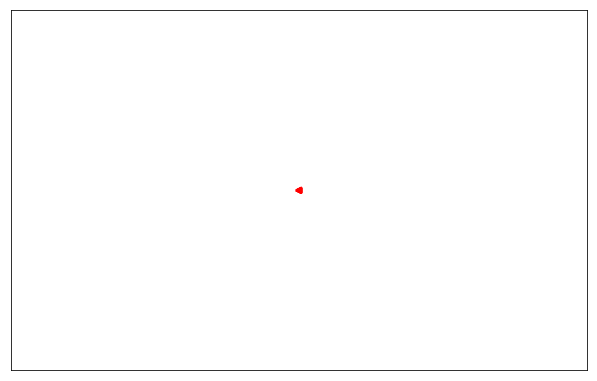

In [61]:
# visualize the sequence
def update(time):
  scatter.set_offsets(flock_arr[time])

fig = plt.figure(figsize=(8, 5))
ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=True)
scatter = ax.scatter(P[:,0], P[:,1], s=30, facecolor="red", edgecolor="None", alpha=0.5, marker='<')

# interval = time between frames in milliseconds
animation = FuncAnimation(fig, update, interval=20, frames=len(flock_arr))
ax.set_xlim(*domains['x'])
ax.set_ylim(*domains['y'])
ax.set_xticks([])
ax.set_yticks([])

HTML(animation.to_html5_video())

# Pitch Grid

In [49]:
import random

# identify available pitch steps within chromatic scale
base_steps = [0, 2, 4, 5, 7, 9, 11]
steps = []
for octave in [3,4,5]:
  steps += [i+(octave*12) for i in base_steps]

# identify the number of distinct pitches in each dimension
n_x_stops = 10
n_y_stops = 10

# quantize out a grid
x_stops = np.linspace(domains['x'][0], domains['x'][1], num=n_x_stops, endpoint=False)
y_stops = np.linspace(domains['y'][0], domains['y'][1], num=n_y_stops, endpoint=False)

# create the coordinate grid
coord_grid = np.array(np.meshgrid(x_stops, y_stops)).T

# create the grid of pitch steps
pitch_grid = np.zeros((n_x_stops, n_y_stops))
kdx = 0
for idx, i in enumerate(pitch_grid):
  for jdx, j in enumerate(i):
    pitch_grid[idx, jdx] = steps[kdx]
    kdx = kdx+1
    if kdx >= len(steps): kdx = 0
pitch_grid = pitch_grid.astype('int')

In [50]:
pitch_grid

array([[36, 38, 40, 41, 43, 45, 47, 48, 50, 52],
       [53, 55, 57, 59, 60, 62, 64, 65, 67, 69],
       [71, 36, 38, 40, 41, 43, 45, 47, 48, 50],
       [52, 53, 55, 57, 59, 60, 62, 64, 65, 67],
       [69, 71, 36, 38, 40, 41, 43, 45, 47, 48],
       [50, 52, 53, 55, 57, 59, 60, 62, 64, 65],
       [67, 69, 71, 36, 38, 40, 41, 43, 45, 47],
       [48, 50, 52, 53, 55, 57, 59, 60, 62, 64],
       [65, 67, 69, 71, 36, 38, 40, 41, 43, 45],
       [47, 48, 50, 52, 53, 55, 57, 59, 60, 62]])

# Random simulation

In [98]:
from collections import defaultdict

m = mido.MidiFile()
m.tracks.append(mido.MidiTrack())

time_scalar = 1200 # beats per unit in i
times = {i: 0 for i in steps} # d[note] = time the note was pressed
pressed = {i: False for i in steps} # d[note] = pressed or not

# store all times in absolute coords
for i in range(10): # time
  new_notes = [random.choice(steps) for _ in range(random.choice([2,3,4]))]
  # end each played note that's not in the new notes
  print(i, new_notes)
  for note in pressed:
    if not pressed[note]: continue
    if note not in new_notes:
      m.tracks[0].append( mido.Message('note_off', note=note, time=i*time_scalar) )
      pressed[note] = False
  # add the new notes
  for note in new_notes:
    if not pressed[note]:
      pressed[note] = True
      times[note] = i
      m.tracks[0].append( mido.Message('note_on', note=note, time=i*time_scalar) )
      
# convert times to relative offsets
last_time = 0
for i in m.tracks[0]:
  t = i.time
  i.time = i.time - last_time
  last_time = t
  
# save and play the midi
play_midi(m)
m.save('random.mid')

0 [64, 24, 38]
 * pressing 64 0
 * pressing 24 0
 * pressing 38 0
1 [65, 52, 71]
 * unpressing 64 1
 * unpressing 24 1
 * unpressing 38 1
 * pressing 65 1
 * pressing 52 1
 * pressing 71 1
2 [40, 43]
 * unpressing 65 2
 * unpressing 71 2
 * unpressing 52 2
 * pressing 40 2
 * pressing 43 2
3 [41, 62]
 * unpressing 40 3
 * unpressing 43 3
 * pressing 41 3
 * pressing 62 3
4 [62, 28, 50, 59]
 * unpressing 41 4
 * pressing 28 4
 * pressing 50 4
 * pressing 59 4
5 [65, 67, 33]
 * unpressing 28 5
 * unpressing 50 5
 * unpressing 59 5
 * unpressing 62 5
 * pressing 65 5
 * pressing 67 5
 * pressing 33 5
6 [35, 41]
 * unpressing 65 6
 * unpressing 67 6
 * unpressing 33 6
 * pressing 35 6
 * pressing 41 6
7 [71, 52]
 * unpressing 35 7
 * unpressing 41 7
 * pressing 71 7
 * pressing 52 7
8 [53, 45]
 * unpressing 71 8
 * unpressing 52 8
 * pressing 53 8
 * pressing 45 8
9 [29, 28, 60, 65]
 * unpressing 45 9
 * unpressing 53 9
 * pressing 29 9
 * pressing 28 9
 * pressing 60 9
 * pressing 65 9


# Flock simulation

In [59]:
from sklearn.cluster import KMeans
from collections import defaultdict

m = mido.MidiFile()
m.tracks.append(mido.MidiTrack())

step = 1 # how often to sample frames
time_scalar = 1200 # beats per unit in i
times = {i: 0 for i in steps} # d[note] = time the note was pressed
pressed = {i: False for i in steps} # d[note] = pressed or not

# store all times in absolute coords
flock_arr = np.load('flock-simulation.npy')
for idx, i in enumerate(flock_arr): # time
  if idx % step != 0: continue
  model = KMeans(n_clusters=3).fit(i)
  frame_positions = model.cluster_centers_
  # convert the k flock centroid positions to notes
  frame_notes = []
  for x, y in frame_positions:
    # find the index offsets of x, y in the coords grid
    x_pos = np.where(x_stops < x)[0][-1]
    y_pos = np.where(y_stops < y)[0][-1]
    # get the pitch that corresponds with the centroid
    frame_notes.append( pitch_grid[x_pos, y_pos] )
  # end each played note that's not in the new notes
  for note in pressed:
    if not pressed[note]: continue
    if note not in frame_notes:
      print(idx, 'note_off', note)
      m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      pressed[note] = False
  # add the new notes
  for note in frame_notes:
    if not pressed[note]:
      print(idx, 'note_on', note)
      pressed[note] = True
      times[note] = idx
      m.tracks[0].append( mido.Message('note_on', note=note, time=idx*time_scalar) )
# close all open notes
for note in pressed:
  if not pressed[note]: continue
  m.tracks[0].append( mido.Message('note_off', note=note, time=idx*time_scalar) )
      
# convert times to relative offsets
last_time = 0
for i in m.tracks[0]:
  t = i.time
  i.time = i.time - last_time
  last_time = t

# save the result
m.save('flock.mid')

0 note_on 41
0 note_on 57
0 note_on 40
20 note_off 40
25 note_off 41
25 note_on 59
25 note_on 40
39 note_off 57
39 note_on 55
48 note_off 59
48 note_on 57
50 note_off 57
50 note_on 59
51 note_off 59
51 note_on 57
53 note_off 57
53 note_on 59
59 note_off 59
59 note_on 57
60 note_off 57
60 note_on 59
62 note_off 59
62 note_on 57
63 note_off 57
63 note_on 59
68 note_off 55
68 note_on 53
69 note_off 59
69 note_on 57
79 note_off 40
79 note_on 38
80 note_off 38
80 note_on 40
82 note_off 40
82 note_on 38
98 note_off 53
98 note_off 57
98 note_on 52
102 note_off 52
102 note_on 69
103 note_off 69
103 note_on 52
105 note_on 36
112 note_off 52
112 note_on 69
114 note_off 69
114 note_on 71
117 note_off 38
117 note_off 71
117 note_on 47
120 note_on 53
124 note_off 36
124 note_on 71
136 note_off 53
136 note_on 52
150 note_off 71
150 note_on 69
161 note_off 47
161 note_on 45
162 note_off 45
162 note_on 47
163 note_off 47
163 note_on 45
166 note_off 45
166 note_on 47
169 note_off 47
169 note_off 52
169

963 note_off 38
963 note_on 40
964 note_off 40
964 note_on 38
967 note_off 38
967 note_on 55
968 note_off 48
968 note_on 47
972 note_off 60
972 note_on 59
974 note_off 55
974 note_on 38
984 note_off 38
984 note_on 55
991 note_off 55
991 note_on 53
994 note_off 59
994 note_on 57
995 note_off 47
995 note_on 45


In [70]:
m.tracks[0].insert(0, mido.MetaMessage('set_tempo', tempo=990))
m.ticks_per_beat = 120
m.save('flock.mid')

In [71]:
os.system('timidity flock.mid -Ow -o - | ffmpeg -i - -acodec libmp3lame -ab 64k flock.mp3')

256

In [76]:
animation.save('flock.mp4', fps=20)

# Streaming midi

In [56]:
import mido
from mido.backends import rtmidi # one must import the backend before it's available

mido.set_backend('mido.backends.rtmidi', load=True)
out_port = mido.open_output('mido_port')

print(portmidi.get_devices())
print(mido.get_output_names())

msg = mido.Message('note_on', note=60)
out_port.send(msg)

[{'opened': False, 'is_input': 1, 'is_output': 0, 'interface': 'CoreMIDI', 'name': 'mido_port', 'id': 0}, {'opened': False, 'is_input': 1, 'is_output': 0, 'interface': 'CoreMIDI', 'name': 'mido_port', 'id': 1}, {'opened': False, 'is_input': 0, 'is_output': 1, 'interface': 'CoreMIDI', 'name': 'mido_port', 'id': 2}]
['mido_port']
